In [ ]:
import os, glob, random
from pathlib import Path
from typing import Tuple, List, Optional

import numpy as np
import pandas as pd
import pydicom
import nibabel as nib
from scipy import ndimage
import matplotlib.pyplot as plt

SERIES_ROOT = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/series"
TRAIN_CSV   = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/train.csv"  
LOCALIZERS_CSV = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/train_localizers.csv"  
SEGS_ROOT   = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/segmentations"
TARGET_DEPTH  = 32
TARGET_HEIGHT = 384
TARGET_WIDTH  = 384

# How many examples to EDA
N_EXAMPLES = 8
random.seed(13)

print("Paths:")
for p in [SERIES_ROOT, TRAIN_CSV, SEGS_ROOT]:
    print(" ", p, "->", "FOUND" if os.path.exists(p) else "MISSING")

Paths:
  D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/series -> FOUND
  D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/train.csv -> FOUND
  D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/segmentations -> FOUND


In [2]:
def read_dicom_series(series_dir: str):
    """
    Load a DICOM series into 3D HU volume with spacing and minimal meta.
    Returns: vol_hu (D,H,W), spacing (dz,dy,dx), meta(dict)
    """
    files = []
    for root, _, fs in os.walk(series_dir):
        for f in fs:
            path = os.path.join(root, f)
            try:
                ds = pydicom.dcmread(path, stop_before_pixels=True, force=True)
                if hasattr(ds, "SOPInstanceUID"):
                    files.append(path)
            except Exception:
                continue
    if not files:
        raise FileNotFoundError(f"No DICOM slices under: {series_dir}")

    # lightweight header read for sort
    def _hdr(p):
        return pydicom.dcmread(p, stop_before_pixels=True, force=True)
    hdrs = [_hdr(p) for p in files]

    def _zpos(h):
        try:
            return float(h.ImagePositionPatient[2])
        except Exception:
            return None

    items, missing_z = [], False
    for p, h in zip(files, hdrs):
        z = _zpos(h)
        if z is None:
            missing_z = True
        inst = getattr(h, "InstanceNumber", None)
        items.append((p, h, z, inst))

    # sort
    items.sort(key=(lambda x: (x[3] if x[3] is not None else 1e9)) if missing_z else (lambda x: x[2]))

    # read pixels (HU)
    slices, pixel_spacings, positions = [], [], []
    series_uid, orientation = None, None
    for p, h, z, inst in items:
        ds = pydicom.dcmread(p, force=True)
        arr = ds.pixel_array.astype(np.int16)
        slope = float(getattr(ds, "RescaleSlope", 1.0))
        intercept = float(getattr(ds, "RescaleIntercept", 0.0))
        hu = arr * slope + intercept
        slices.append(hu)
        series_uid = series_uid or getattr(ds, "SeriesInstanceUID", None)
        pixel_spacings.append(tuple(map(float, getattr(ds, "PixelSpacing", [1.0, 1.0]))))
        positions.append(tuple(map(float, getattr(ds, "ImagePositionPatient", [0,0,0]))))
        orientation = orientation or getattr(ds, "ImageOrientationPatient", None)

    vol_hu = np.stack(slices, axis=0)  # (D,H,W)

    # spacing
    dy = float(np.median([ps[0] for ps in pixel_spacings]))
    dx = float(np.median([ps[1] for ps in pixel_spacings]))
    zs = sorted([p[2] for p in positions if p is not None])
    if len(zs) >= 2:
        dz = float(np.median(np.abs(np.diff(zs))))
    else:
        dz = float(getattr(hdrs[0], "SliceThickness", 1.0))
    spacing = (dz, dy, dx)

    meta = dict(
        SeriesInstanceUID=series_uid,
        orientation=orientation,
        n_slices=vol_hu.shape[0],
        spacing=spacing,
        path=series_dir,
    )
    return vol_hu, spacing, meta


def resize_volume_3d(volume: np.ndarray, target_shape, order: int = 1) -> np.ndarray:
    """
    Match your pipeline: scipy.ndimage.zoom with linear (order=1) for images
    and nearest (order=0) for masks; then clip/pad.
    """
    current = volume.shape
    tgt = (int(target_shape[0]), int(target_shape[1]), int(target_shape[2]))
    if current == tgt:
        return volume
    zoom_factors = [tgt[i] / current[i] for i in range(3)]
    out = ndimage.zoom(volume, zoom_factors, order=order, mode='nearest')
    out = out[:tgt[0], :tgt[1], :tgt[2]]
    pad = [
        (0, max(0, tgt[0] - out.shape[0])),
        (0, max(0, tgt[1] - out.shape[1])),
        (0, max(0, tgt[2] - out.shape[2])),
    ]
    if any(p[1] > 0 for p in pad):
        out = np.pad(out, pad, mode='edge')
    return out


def load_nifti_mask(nii_path: str):
    """
    Load NIfTI mask and return (D,H,W) uint8 and spacing (dz,dy,dx).
    Assume nib returns (X,Y,Z) -> transpose to (Z,Y,X).
    """
    nii = nib.load(nii_path)
    data = nii.get_fdata()
    while data.ndim > 3:  # squeeze 4D
        data = data[..., 0]
    # transpose to (Z,Y,X) = (D,H,W)
    arr = np.transpose(data, (2, 1, 0)).astype(np.float32)
    arr = (arr > 0).astype(np.uint8)

    hdr = nii.header
    pixdim = hdr.get("pixdim", None)
    if pixdim is not None and len(pixdim) >= 4:
        dx = float(pixdim[1]); dy = float(pixdim[2]); dz = float(pixdim[3])
        spacing = (dz, dy, dx)
    else:
        spacing = (1.0, 1.0, 1.0)

    return arr, spacing


In [3]:
def crude_vessel_candidate_from_hu(vol_hu: np.ndarray, hu_thresh: int = 200) -> np.ndarray:
    return (vol_hu >= hu_thresh).astype(np.uint8)

def dice(a: np.ndarray, b: np.ndarray, eps=1e-6):
    a = (a > 0).astype(np.uint8); b = (b > 0).astype(np.uint8)
    inter = (a & b).sum()
    return (2*inter + eps) / (a.sum() + b.sum() + eps)

def flip_axes(m: np.ndarray, fz=False, fy=False, fx=False):
    o = m
    if fz: o = o[::-1]
    if fy: o = o[:, ::-1, :]
    if fx: o = o[:, :, ::-1]
    return o

def rot_k90(m: np.ndarray, k=0):
    if k % 4 == 0: return m
    return np.stack([np.rot90(s, k) for s in m], axis=0)

def best_orientation(mask: np.ndarray, target: np.ndarray):
    best = {"dice": -1.0, "k": 0, "fz": False, "fy": False, "fx": False}
    best_m = mask
    for k in [0,1,2,3]:
        r = rot_k90(mask, k)
        for fz in [False, True]:
            for fy in [False, True]:
                for fx in [False, True]:
                    cand = flip_axes(r, fz, fy, fx)
                    if cand.shape != target.shape:  # safety
                        continue
                    d = dice(cand, target)
                    if d > best["dice"]:
                        best.update({"dice": float(d), "k": k, "fz": fz, "fy": fy, "fx": fx})
                        best_m = cand
    return best_m, best

def show_triptych(ct, msk, title=""):
    D = ct.shape[0]; mid = D//2
    fig, axs = plt.subplots(1, 3, figsize=(12,4))
    axs[0].imshow(ct[mid], cmap="gray")
    axs[0].imshow(msk[mid], alpha=0.3)
    axs[0].set_title("Axial mid"); axs[0].axis("off")

    axs[1].imshow(ct.max(axis=2), cmap="gray")
    axs[1].imshow(msk.max(axis=2), alpha=0.3)
    axs[1].set_title("Sagittal MIP"); axs[1].axis("off")

    axs[2].imshow(ct.max(axis=1), cmap="gray")
    axs[2].imshow(msk.max(axis=1), alpha=0.3)
    axs[2].set_title("Coronal MIP"); axs[2].axis("off")
    fig.suptitle(title)
    plt.show()


In [ ]:
def discover_seg_nii(root: str) -> List[str]:
    # you gave example: *_cowseg.nii; include .nii.gz just in case
    pats = ["**/*_cowseg.nii", "**/*.nii", "**/*.nii.gz"]
    out = []
    seen = set()
    for pat in pats:
        for p in glob.glob(os.path.join(root, pat), recursive=True):
            if p not in seen:
                seen.add(p); out.append(p)
    return out

def uid_from_seg_name(path: str) -> str:
    # "1.2.826...._cowseg.nii" -> UID prefix
    return Path(path).name.split("_")[0]

def series_dir_for_uid(uid: str) -> Optional[str]:
    cand = os.path.join(SERIES_ROOT, uid)
    if os.path.isdir(cand):
        return cand
    # fallback: shallow search one level
    for d in glob.glob(os.path.join(SERIES_ROOT, "*")):
        dd = os.path.join(d, uid)
        if os.path.isdir(dd):
            return dd
    return None

segs = discover_seg_nii(SEGS_ROOT)
print(f"Found {len(segs)} NIfTI segmentations")
sample_segs = segs[:N_EXAMPLES]
print(f"Using {len(sample_segs)} for EDA")
sample_segs


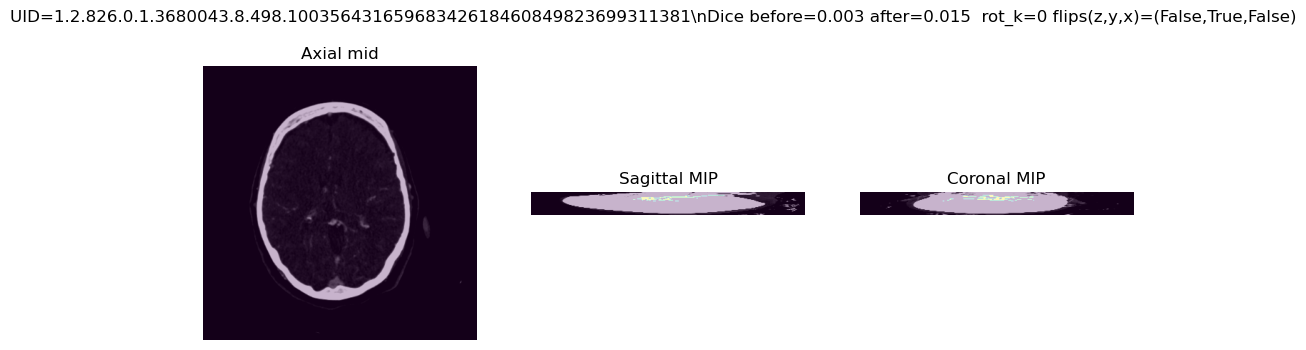

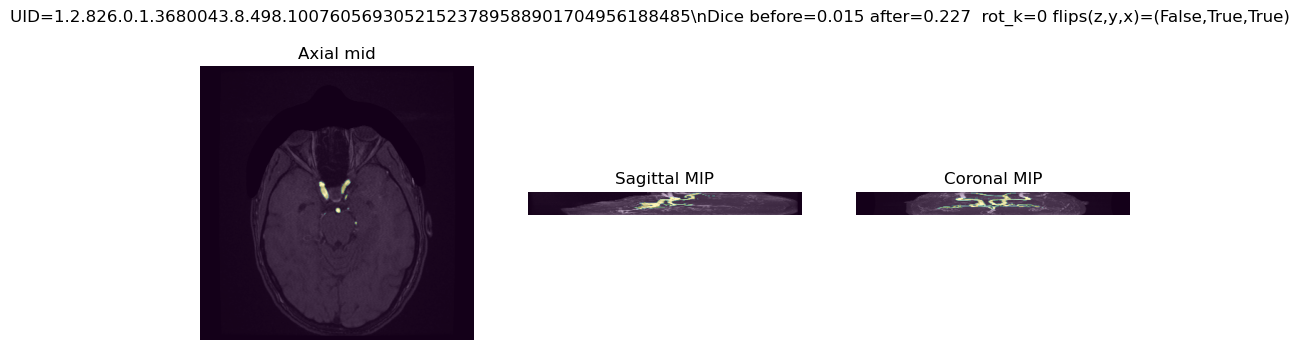

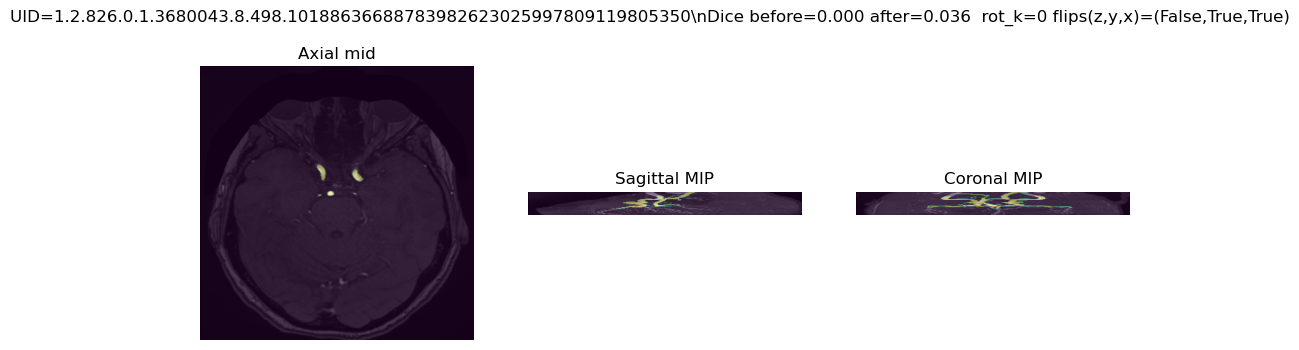

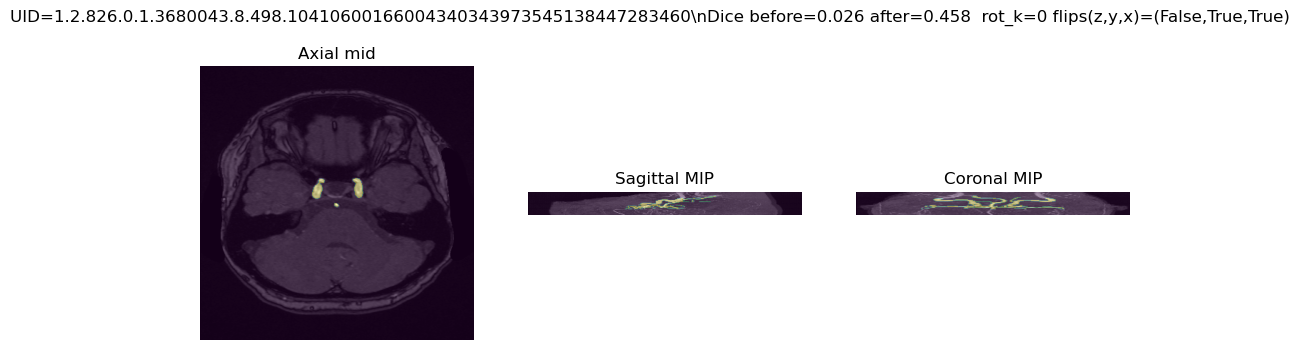

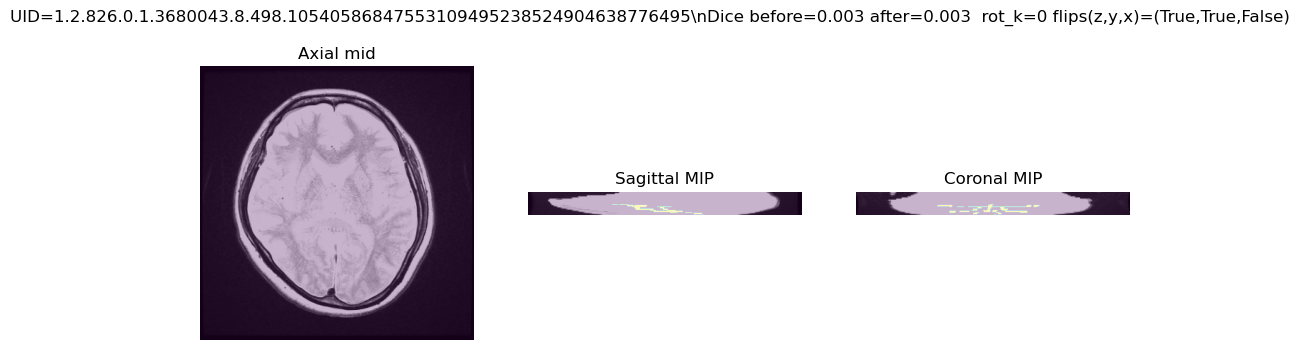

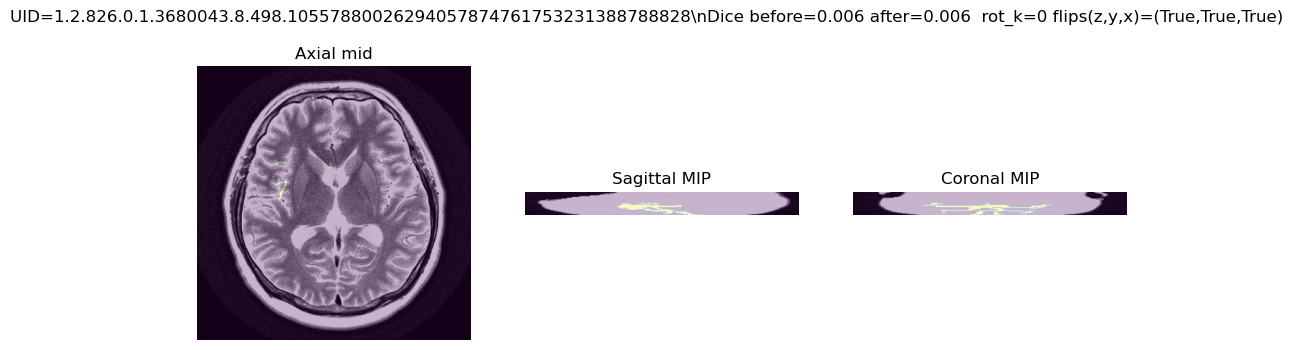

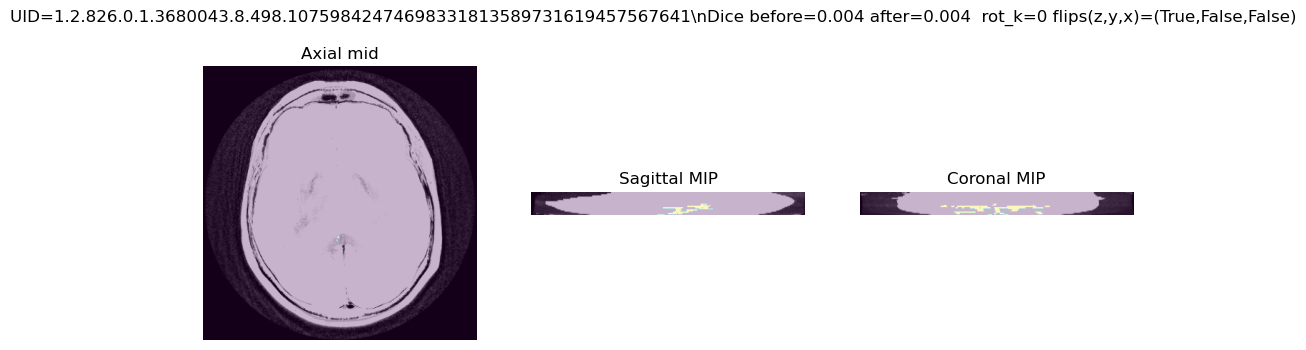

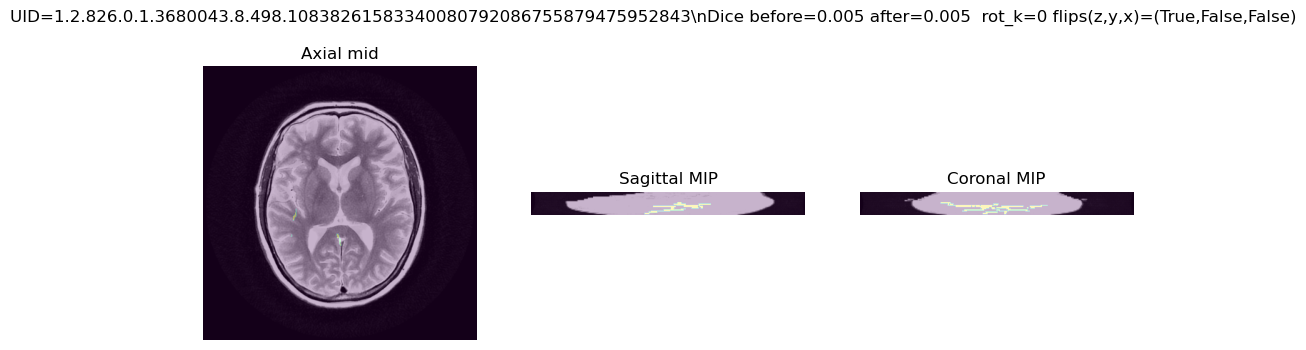

,uid,series_dir,n_slices_orig,spacing_dz_dy_dx,dice_before,dice_after,rot_k,flip_z,flip_y,flip_x,mask_pos_frac,z_min,z_max
0,1.2.826.0.1.3680043.8.498.10035643165968342618...,D:/User Data/Downloads/rsna-intracranial-aneur...,228,"(0.7000000000000455, 0.474609375, 0.474609375)",0.002739,0.014512,0,False,True,False,0.000427,4,12
1,1.2.826.0.1.3680043.8.498.10076056930521523789...,D:/User Data/Downloads/rsna-intracranial-aneur...,136,"(0.7997999999999994, 0.2148, 0.2148)",0.014508,0.226612,0,False,True,True,0.001067,1,23
2,1.2.826.0.1.3680043.8.498.10188636688783982623...,D:/User Data/Downloads/rsna-intracranial-aneur...,136,"(0.6684796212550026, 0.52083337306976, 0.52083...",0.000467,0.036168,0,False,True,True,0.001784,0,23
3,1.2.826.0.1.3680043.8.498.10410600166004340343...,D:/User Data/Downloads/rsna-intracranial-aneur...,95,"(0.8767847374380011, 0.4296875, 0.4296875)",0.026311,0.458481,0,False,True,True,0.001435,5,23
4,1.2.826.0.1.3680043.8.498.10540586847553109495...,D:/User Data/Downloads/rsna-intracranial-aneur...,21,"(6.485500000000002, 0.4297, 0.4297)",0.003399,0.003433,0,True,True,False,0.000614,17,31


In [ ]:
summary_rows = []

for seg_path in sample_segs:
    uid = uid_from_seg_name(seg_path)
    sdir = series_dir_for_uid(uid)
    if sdir is None:
        print(f"[SKIP] No series dir for UID={uid} ({seg_path})")
        continue

    try:
        # CT -> HU -> display-normalized + resampled to target
        vol_hu, spacing, meta = read_dicom_series(sdir)
        # display normalization (CTA-ish): [0,700] to [0,1]
        disp = np.clip((vol_hu.astype(np.float32) - 0) / 700.0, 0.0, 1.0)
        ct_tgt = resize_volume_3d(disp, (TARGET_DEPTH, TARGET_HEIGHT, TARGET_WIDTH), order=1)

        # NIfTI mask -> resample to target (nearest)
        mask_raw, mask_spacing = load_nifti_mask(seg_path)
        mask_tgt = resize_volume_3d(mask_raw.astype(np.uint8),
                                    (TARGET_DEPTH, TARGET_HEIGHT, TARGET_WIDTH),
                                    order=0).astype(np.uint8)

        # Crude vessel candidate from HU on the same target grid
        hu_tgt = resize_volume_3d(vol_hu, (TARGET_DEPTH, TARGET_HEIGHT, TARGET_WIDTH), order=1)
        vessel_cand = crude_vessel_candidate_from_hu(hu_tgt, hu_thresh=200)

        # Try orientation (in-plane k*90, plus z/y/x flips)
        oriented_mask, info = best_orientation(mask_tgt, vessel_cand)
        d0 = dice(mask_tgt, vessel_cand)
        d1 = dice(oriented_mask, vessel_cand)

        ttl = f"UID={uid}\\nDice before={d0:.3f} after={d1:.3f}  rot_k={info['k']} flips(z,y,x)=({info['fz']},{info['fy']},{info['fx']})"
        show_triptych(ct_tgt, oriented_mask, title=ttl)

        pos_frac = float(oriented_mask.mean())
        z_proj = oriented_mask.sum(axis=(1,2))
        z_min = int(np.argmax(z_proj > 0)) if (z_proj > 0).any() else -1
        z_max = int(len(z_proj) - 1 - np.argmax(z_proj[::-1] > 0)) if (z_proj > 0).any() else -1

        summary_rows.append(dict(
            uid=uid,
            series_dir=sdir,
            n_slices_orig=meta.get("n_slices"),
            spacing_dz_dy_dx=meta.get("spacing"),
            dice_before=d0,
            dice_after=d1,
            rot_k=info["k"],
            flip_z=info["fz"],
            flip_y=info["fy"],
            flip_x=info["fx"],
            mask_pos_frac=pos_frac,
            z_min=z_min,
            z_max=z_max,
        ))
    except Exception as e:
        print(f"[ERROR] UID={uid} seg={seg_path} -> {e}")

summary_df = pd.DataFrame(summary_rows)
summary_df.head()


In [ ]:
out_csv = "vessel_mask_eda_summary.csv"  
summary_df.to_csv(out_csv, index=False)
print("Wrote:", os.path.abspath(out_csv))

In [ ]:
import numpy as np
from scipy.ndimage import map_coordinates
import nibabel as nib

def dicom_affine_from_headers(headers, positions):
    """Voxel->LPS affine for the ORIGINAL grid (D0,H0,W0)."""
    h0 = headers[0]
    iop = np.array(getattr(h0, "ImageOrientationPatient")).astype(float)
    row = iop[:3]    # direction of rows (y index)
    col = iop[3:]    # direction of cols (x index)
    dy, dx = map(float, getattr(h0, "PixelSpacing", [1.0, 1.0]))

    pos = np.array([p if p is not None else getattr(h0, "ImagePositionPatient") for p in positions], float)
    if len(pos) >= 2:
        v = pos[-1] - pos[0]
        sl = v / (np.linalg.norm(v) + 1e-8)
        dz_proj = (pos[1:] - pos[:-1]) @ sl
        dz = float(np.median(np.abs(dz_proj))) if len(dz_proj) else float(getattr(h0, "SliceThickness", 1.0))
    else:
        sl = np.cross(row, col)
        dz  = float(getattr(h0, "SliceThickness", 1.0))

    origin = np.array(getattr(h0, "ImagePositionPatient"), float)
    A = np.eye(4, dtype=float)
    A[:3,0] = col * dx
    A[:3,1] = row * dy
    A[:3,2] = sl  * dz
    A[:3,3] = origin
    return A, (dz, dy, dx)

def scaled_target_affine(A_orig, orig_shape, out_shape):
    """
    Create a target voxel->LPS affine for the resized grid that covers the SAME FOV.
    Scale each axis step by (orig_dim / out_dim).
    """
    D0,H0,W0 = orig_shape
    D,H,W    = out_shape
    sx = W0 / float(W)  # x/cols scale
    sy = H0 / float(H)  # y/rows scale
    sz = D0 / float(D)  # z/slices scale
    A_tgt = A_orig.copy()
    A_tgt[:3,0] *= sx
    A_tgt[:3,1] *= sy
    A_tgt[:3,2] *= sz
    return A_tgt

def resample_mask_world_to_grid(nii_path, target_affine, out_shape):
    """
    Resample NIfTI mask into grid defined by (target_affine, out_shape).
    target_affine is voxel->LPS for the target grid.
    """
    img = nib.load(nii_path)
    img = nib.as_closest_canonical(img)  # voxel->RAS
    data = img.get_fdata().astype(np.float32)
    while data.ndim > 3:
        data = data[...,0]
    nii_aff = img.affine  # voxel->RAS
    L2R = np.diag([-1,-1,1,1]).astype(float)  # LPS->RAS

    D,H,W = out_shape
    zz, yy, xx = np.meshgrid(np.arange(D), np.arange(H), np.arange(W), indexing="ij")
    ijk = np.stack([xx, yy, zz, np.ones_like(xx)], axis=0).reshape(4, -1)  # (4,N) in (x,y,z,1) index order

    # target grid index -> LPS -> RAS -> NIfTI voxel
    X_lps = target_affine @ ijk
    X_ras = L2R @ X_lps
    v = np.linalg.inv(nii_aff) @ X_ras
    vx, vy, vz = v[0].reshape(out_shape), v[1].reshape(out_shape), v[2].reshape(out_shape)

    samp = map_coordinates(data, [vz, vy, vx], order=0, mode="nearest")
    return (samp > 0.5).astype(np.uint8)

[SKIP] no series for 1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381.nii
1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381 mask voxels: 279


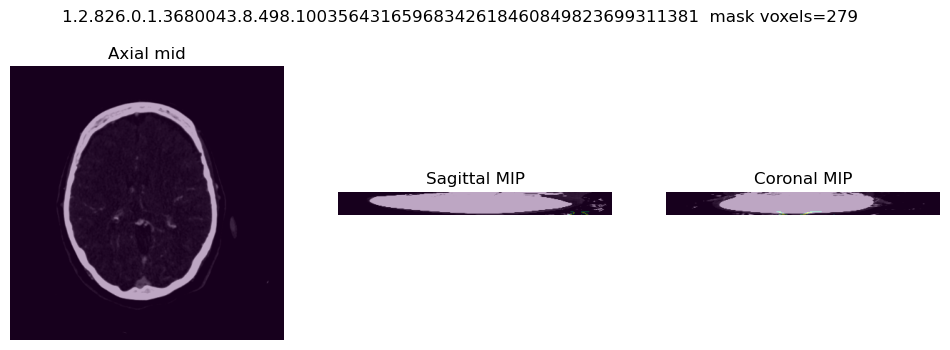

1.2.826.0.1.3680043.8.498.10035643165968342618460849823699311381 mask voxels: 279


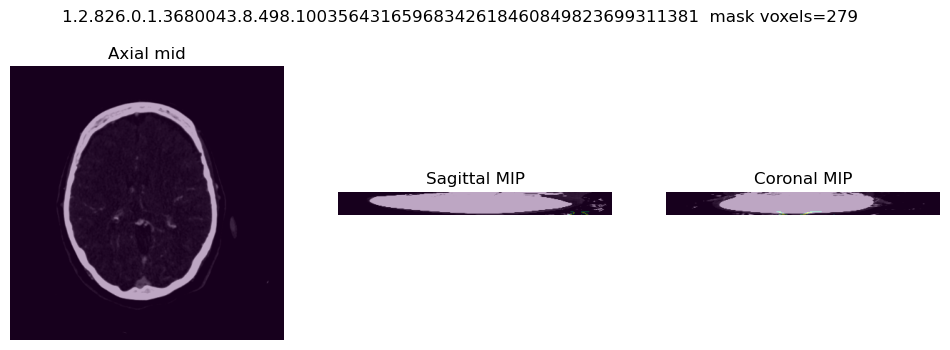

[SKIP] no series for 1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485.nii
1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485 mask voxels: 0


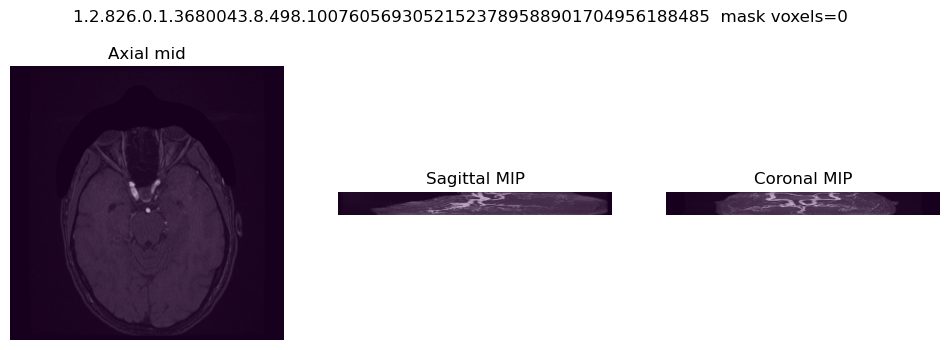

1.2.826.0.1.3680043.8.498.10076056930521523789588901704956188485 mask voxels: 0


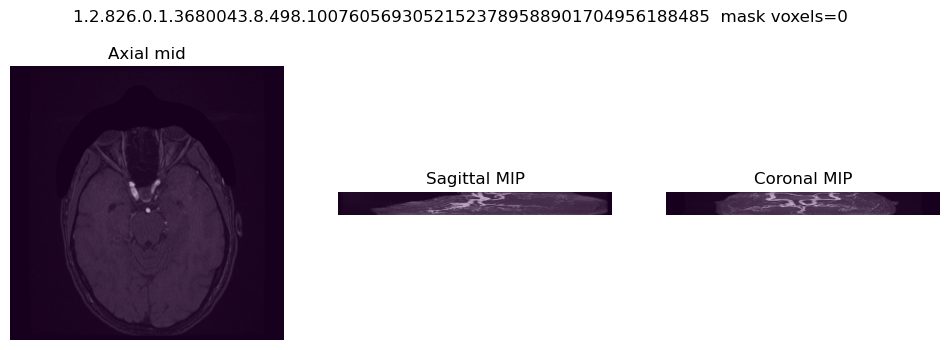

[SKIP] no series for 1.2.826.0.1.3680043.8.498.10188636688783982623025997809119805350.nii
1.2.826.0.1.3680043.8.498.10188636688783982623025997809119805350 mask voxels: 5063


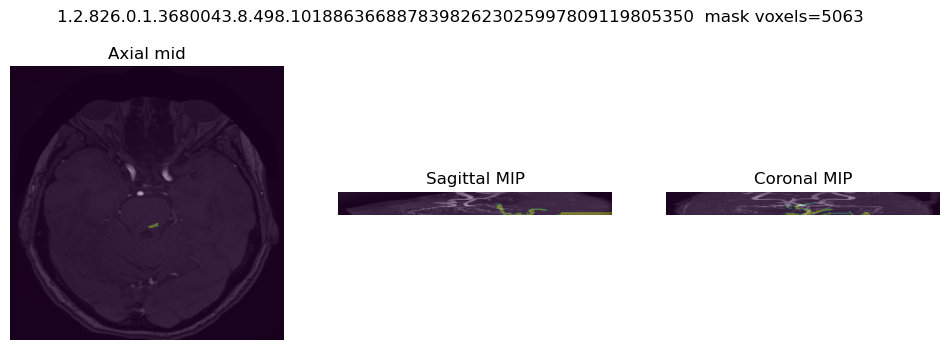

Wrote: d:\User Data\Downloads\rsna-intracranial-aneurysm-detection\vessel_mask_worldspace_eda.csv


In [ ]:
import os, glob, pydicom, numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

TARGET_DEPTH, TARGET_HEIGHT, TARGET_WIDTH = 32, 384, 384
OUT_SHAPE = (TARGET_DEPTH, TARGET_HEIGHT, TARGET_WIDTH)

def read_dicom_series_with_headers(series_dir: str):
    files = []
    for root,_,fs in os.walk(series_dir):
        for f in fs:
            p = os.path.join(root,f)
            try:
                ds = pydicom.dcmread(p, stop_before_pixels=True, force=True)
                if hasattr(ds, "SOPInstanceUID"):
                    files.append(p)
            except: pass
    if not files: raise FileNotFoundError(series_dir)

    hdrs = [pydicom.dcmread(p, stop_before_pixels=True, force=True) for p in files]
    def zpos(h):
        try: return float(h.ImagePositionPatient[2])
        except: return None
    items = []
    miss = False
    for p,h in zip(files, hdrs):
        z = zpos(h); miss = miss or (z is None)
        inst = getattr(h, "InstanceNumber", None)
        items.append((p,h,z,inst))
    items.sort(key=(lambda x: (x[3] if x[3] is not None else 1e9)) if miss else (lambda x: x[2]))

    vol, headers, positions, pxsp = [], [], [], []
    for p,h,_,_ in items:
        ds = pydicom.dcmread(p, force=True)
        arr = ds.pixel_array.astype(np.int16)
        slope = float(getattr(ds,"RescaleSlope",1.0))
        inter = float(getattr(ds,"RescaleIntercept",0.0))
        vol.append(arr*slope + inter)
        headers.append(ds)
        pxsp.append(tuple(map(float, getattr(ds,"PixelSpacing",[1.0,1.0]))))
        pos = getattr(ds,"ImagePositionPatient", None)
        positions.append(tuple(map(float,pos)) if pos is not None else None)
    vol = np.stack(vol,0)
    return vol, headers, positions, pxsp[0]

def discover_seg_nii(root: str):
    pats = ["**/*_cowseg.nii", "**/*.nii", "**/*.nii.gz"]
    out = []
    for pat in pats:
        out += glob.glob(os.path.join(root, pat), recursive=True)
    return sorted(out)

def uid_from_seg_name(path: str): return Path(path).name.split("_")[0]
def series_dir_for_uid(uid: str):
    cand = os.path.join(SERIES_ROOT, uid)
    if os.path.isdir(cand): return cand
    for d in glob.glob(os.path.join(SERIES_ROOT,"*")):
        dd = os.path.join(d, uid)
        if os.path.isdir(dd): return dd
    return None

def show_triptych(ct, msk, title=""):
    D = ct.shape[0]; mid = D//2
    fig, axs = plt.subplots(1,3, figsize=(12,4))
    axs[0].imshow(ct[mid], cmap="gray"); axs[0].imshow(msk[mid], alpha=0.35); axs[0].set_title("Axial mid"); axs[0].axis("off")
    axs[1].imshow(ct.max(axis=2), cmap="gray"); axs[1].imshow(msk.max(axis=2), alpha=0.35); axs[1].set_title("Sagittal MIP"); axs[1].axis("off")
    axs[2].imshow(ct.max(axis=1), cmap="gray"); axs[2].imshow(msk.max(axis=1), alpha=0.35); axs[2].set_title("Coronal MIP"); axs[2].axis("off")
    fig.suptitle(title); plt.show()

# run on a few and write CSV 
segs = discover_seg_nii(SEGS_ROOT)
sample = segs[:8]  # or pick a larger slice once it's working

rows = []
for seg_path in sample:
    uid = uid_from_seg_name(seg_path)
    sdir = series_dir_for_uid(uid)
    if not sdir:
        print(f"[SKIP] no series for {uid}")
        continue

    vol_hu, hdrs, positions, pxsp = read_dicom_series_with_headers(sdir)
    A_orig, _ = dicom_affine_from_headers(hdrs, positions)
    A_tgt = scaled_target_affine(A_orig, vol_hu.shape, OUT_SHAPE)

    # resample mask into target grid
    mask = resample_mask_world_to_grid(seg_path, A_tgt, OUT_SHAPE)

    # make a display-normalized CT also at target grid (simple zoom is fine for visualization)
    disp = np.clip((vol_hu.astype(np.float32) - 0)/700.0, 0.0, 1.0)
    ct_tgt = ndimage.zoom(disp, [OUT_SHAPE[0]/vol_hu.shape[0],
                                 OUT_SHAPE[1]/vol_hu.shape[1],
                                 OUT_SHAPE[2]/vol_hu.shape[2]], order=1, mode='nearest')

    # quick metrics
    pos = int(mask.sum())
    pos_frac = float(mask.mean())
    z_nonzero = mask.sum(axis=(1,2))
    z_min = int(np.argmax(z_nonzero>0)) if (z_nonzero>0).any() else -1
    z_max = int(len(z_nonzero)-1-np.argmax(z_nonzero[::-1]>0)) if (z_nonzero>0).any() else -1

    # visualize a couple to confirm non-empty overlays
    print(uid, "mask voxels:", pos)
    show_triptych(ct_tgt, mask, title=f"{uid}  mask voxels={pos}")

    rows.append(dict(
        uid=uid, series_dir=sdir,
        mask_voxels=pos, mask_pos_frac=pos_frac,
        z_min=z_min, z_max=z_max,
    ))

world_csv = "vessel_mask_worldspace_eda.csv"
pd.DataFrame(rows).to_csv(world_csv, index=False)
print("Wrote:", os.path.abspath(world_csv))


# 3D-UNet + dataloader

In [ ]:
# eventually add to models/unet3d.py
import torch, torch.nn as nn, torch.nn.functional as F

def _norm3d(c, kind="in"):
    return nn.InstanceNorm3d(c) if kind=="in" else nn.BatchNorm3d(c)

class DoubleConv3d(nn.Module):
    def __init__(self, c_in, c_out, norm="in"):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv3d(c_in, c_out, 3, padding=1, bias=False),
            _norm3d(c_out, norm), nn.ReLU(inplace=True),
            nn.Conv3d(c_out, c_out, 3, padding=1, bias=False),
            _norm3d(c_out, norm), nn.ReLU(inplace=True),
        )
    def forward(self, x): return self.block(x)

class UNet3DSmall(nn.Module):
    """
    U-Net 3D: in_ch=1 (CTA volume), out_ch=1 (vessel prob), base=32, depth=3
    Shapes assume inputs like (B,1,32,384,384). Will also work with smaller tiles.
    """
    def __init__(self, in_ch=1, out_ch=1, base=32, norm="in"):
        super().__init__()
        b = base
        self.enc1 = DoubleConv3d(in_ch, b, norm)
        self.pool1 = nn.MaxPool3d(2)         # /2
        self.enc2 = DoubleConv3d(b, b*2, norm)
        self.pool2 = nn.MaxPool3d(2)         # /4
        self.bott = DoubleConv3d(b*2, b*4, norm)
        self.up2  = nn.ConvTranspose3d(b*4, b*2, 2, stride=2)
        self.dec2 = DoubleConv3d(b*4, b*2, norm)
        self.up1  = nn.ConvTranspose3d(b*2, b, 2, stride=2)
        self.dec1 = DoubleConv3d(b*2, b, norm)
        self.head = nn.Conv3d(b, out_ch, 1)

    def forward(self, x):
        e1 = self.enc1(x)            # B, b,  D,H,W
        e2 = self.enc2(self.pool1(e1))  # B,2b, D/2,H/2,W/2
        b  = self.bott(self.pool2(e2))  # B,4b, D/4,H/4,W/4
        d2 = self.up2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)           # B,2b, D/2,H/2,W/2
        d1 = self.up1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)           # B,b,  D,H,W
        return self.head(d1)         # B,1,  D,H,W

class DiceBCELoss(nn.Module):
    def __init__(self, pos_weight=1.0, smooth=1.0):
        super().__init__()
        self.smooth = smooth
        self.bce = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))
    def forward(self, logits, target):
        bce = self.bce(logits, target)
        probs = torch.sigmoid(logits)
        num = 2.0 * (probs*target).sum(dim=(1,2,3,4)) + self.smooth
        den = probs.sum(dim=(1,2,3,4)) + target.sum(dim=(1,2,3,4)) + self.smooth
        dice = 1.0 - (num/den).mean()
        return bce + dice


In [ ]:
# eventuall add this to data/vessel_dataset.py
import os, glob, json, numpy as np, torch
from torch.utils.data import Dataset
from scipy import ndimage
import nibabel as nib, pydicom

SERIES_ROOT = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/series"
SEGS_ROOT   = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/segmentations"
OUT_SHAPE   = (32, 384, 384)  # (D,H,W)

def read_dicom_series_with_headers(series_dir: str):
    files = []
    for root,_,fs in os.walk(series_dir):
        for f in fs:
            p = os.path.join(root,f)
            try:
                ds = pydicom.dcmread(p, stop_before_pixels=True, force=True)
                if hasattr(ds,"SOPInstanceUID"): files.append(p)
            except: pass
    if not files: raise FileNotFoundError(series_dir)
    hdrs = [pydicom.dcmread(p, stop_before_pixels=True, force=True) for p in files]
    def zpos(h):
        try: return float(h.ImagePositionPatient[2])
        except: return None
    items=[]; miss=False
    for p,h in zip(files, hdrs):
        z=zpos(h); miss = miss or (z is None)
        inst = getattr(h,"InstanceNumber", None)
        items.append((p,h,z,inst))
    items.sort(key=(lambda x: (x[3] if x[3] is not None else 1e9)) if miss else (lambda x: x[2]))
    vol, headers, positions, pxsp = [], [], [], []
    for p,h,_,_ in items:
        ds = pydicom.dcmread(p, force=True)
        arr = ds.pixel_array.astype(np.int16)
        slope = float(getattr(ds,"RescaleSlope",1.0))
        inter = float(getattr(ds,"RescaleIntercept",0.0))
        vol.append(arr*slope + inter)
        headers.append(ds)
        pxsp.append(tuple(map(float, getattr(ds,"PixelSpacing",[1.0,1.0]))))
        pos = getattr(ds,"ImagePositionPatient", None)
        positions.append(tuple(map(float,pos)) if pos is not None else None)
    vol = np.stack(vol,0)  # (D,H,W)
    return vol, headers, positions, pxsp[0]

def dicom_affine_from_headers(headers, positions):
    h0 = headers[0]
    iop = np.array(getattr(h0,"ImageOrientationPatient")).astype(float)
    row = iop[:3]; col = iop[3:]
    dy, dx = map(float, getattr(h0,"PixelSpacing",[1.0,1.0]))
    pos = np.array([p if p is not None else getattr(h0,"ImagePositionPatient") for p in positions], float)
    if len(pos)>=2:
        v = pos[-1]-pos[0]; n = np.linalg.norm(v)+1e-8
        sl = v/n
        dzs = (pos[1:]-pos[:-1]) @ sl
        dz = float(np.median(np.abs(dzs))) if len(dzs) else float(getattr(h0,"SliceThickness",1.0))
    else:
        sl = np.cross(row,col); dz = float(getattr(h0,"SliceThickness",1.0))
    origin = np.array(getattr(h0,"ImagePositionPatient"), float)
    A = np.eye(4,dtype=float)
    A[:3,0] = col*dx; A[:3,1] = row*dy; A[:3,2] = sl*dz; A[:3,3] = origin
    return A, (dz,dy,dx)

def scaled_target_affine(A_orig, orig_shape, out_shape):
    D0,H0,W0 = orig_shape; D,H,W = out_shape
    sx,sy,sz = W0/W, H0/H, D0/D
    A = A_orig.copy()
    A[:3,0]*=sx; A[:3,1]*=sy; A[:3,2]*=sz
    return A

def resample_mask_world_to_grid(nii_path, target_affine, out_shape):
    from scipy.ndimage import map_coordinates
    img = nib.load(nii_path); img = nib.as_closest_canonical(img)
    data = img.get_fdata().astype(np.float32); 
    while data.ndim>3: data = data[...,0]
    nii_aff = img.affine
    L2R = np.diag([-1,-1,1,1]).astype(float)
    D,H,W = out_shape
    zz,yy,xx = np.meshgrid(np.arange(D),np.arange(H),np.arange(W), indexing="ij")
    ijk = np.stack([xx,yy,zz,np.ones_like(xx)], axis=0).reshape(4,-1)
    X_lps = target_affine @ ijk
    X_ras = L2R @ X_lps
    v = np.linalg.inv(nii_aff) @ X_ras
    vx,vy,vz = v[0].reshape(out_shape), v[1].reshape(out_shape), v[2].reshape(out_shape)
    samp = map_coordinates(data, [vz,vy,vx], order=0, mode="nearest")
    return (samp>0.5).astype(np.uint8)

def uid_from_seg_name(path: str): 
    return os.path.basename(path).split("_")[0]
def series_dir_for_uid(uid: str):
    cand = os.path.join(SERIES_ROOT, uid)
    if os.path.isdir(cand): return cand
    for d in glob.glob(os.path.join(SERIES_ROOT,"*")):
        dd = os.path.join(d, uid)
        if os.path.isdir(dd): return dd
    return None

class VesselSegDataset(Dataset):
    """
    Training dataset for 3D vessel segmentation.
    Expects a CSV with column 'uid'. It will:
      - read DICOM series
      - build target affine for OUT_SHAPE
      - resample NIfTI mask into target grid
      - compute CT display volume (0..1) at OUT_SHAPE
      - optionally save (ct,mask) as .npy in precache_dir for speed on next epoch
      - return foreground-biased 3D crops or full volume
    """
    def __init__(self, csv_path, split="train", segs_root=SEGS_ROOT, precache_dir=None,
                 crop_size=(32,256,256), fg_prob=0.7):
        import pandas as pd
        df = pd.read_csv(csv_path)
        self.uids = df[df["split"]==split]["uid"].tolist() if "split" in df.columns else df["uid"].tolist()
        self.segs_root = segs_root
        self.precache_dir = precache_dir
        self.crop_size = crop_size
        self.fg_prob = fg_prob
        if precache_dir: os.makedirs(precache_dir, exist_ok=True)

    def __len__(self): return len(self.uids)

    def _paths(self, uid):
        # seg file
        seg = glob.glob(os.path.join(self.segs_root, f"{uid}*"))  # *_cowseg.nii
        seg_path = seg[0] if seg else None
        sdir = series_dir_for_uid(uid)
        return sdir, seg_path

    def _load_or_build(self, uid):
        cachefile = os.path.join(self.precache_dir, f"{uid}_ct_mask.npy") if self.precache_dir else None
        if cachefile and os.path.exists(cachefile):
            arr = np.load(cachefile, allow_pickle=False)
            ct = arr[0].astype(np.float32)   # (D,H,W) 0..1
            m  = arr[1].astype(np.uint8)     # (D,H,W) {0,1}
            return ct, m
        # build
        sdir, seg_path = self._paths(uid)
        if sdir is None or seg_path is None:
            raise FileNotFoundError(f"Missing series or seg for {uid}")
        vol_hu, hdrs, positions, _ = read_dicom_series_with_headers(sdir)
        A_orig,_ = dicom_affine_from_headers(hdrs, positions)
        A_tgt = scaled_target_affine(A_orig, vol_hu.shape, OUT_SHAPE)
        # mask (world-space resample)
        mask = resample_mask_world_to_grid(seg_path, A_tgt, OUT_SHAPE)  # (D,H,W) 0/1
        # CT display volume 0..1 (same as EDA; you can swap to your exact windowing)
        disp = np.clip((vol_hu.astype(np.float32)-0)/700.0, 0.0, 1.0)
        ct = ndimage.zoom(disp, [OUT_SHAPE[0]/vol_hu.shape[0],
                                 OUT_SHAPE[1]/vol_hu.shape[1],
                                 OUT_SHAPE[2]/vol_hu.shape[2]], order=1, mode='nearest')
        if cachefile:
            np.save(cachefile, np.stack([ct, mask], axis=0), allow_pickle=False)
        return ct, mask

    def _random_crop(self, vol, mask):
        D,H,W = vol.shape
        cd,ch,cw = self.crop_size
        if (cd, ch, cw) == (D,H,W):
            return vol, mask
        # foreground-biased z/y/x center
        if np.random.rand() < self.fg_prob and mask.any():
            zz, yy, xx = np.where(mask>0)
            idx = np.random.randint(len(zz))
            cz, cy, cx = int(zz[idx]), int(yy[idx]), int(xx[idx])
        else:
            cz, cy, cx = np.random.randint(D), np.random.randint(H), np.random.randint(W)
        z0 = np.clip(cz - cd//2, 0, D-cd); y0 = np.clip(cy - ch//2, 0, H-ch); x0 = np.clip(cx - cw//2, 0, W-cw)
        return vol[z0:z0+cd, y0:y0+ch, x0:x0+cw], mask[z0:z0+cd, y0:y0+ch, x0:x0+cw]

    def __getitem__(self, idx):
        uid = self.uids[idx]
        ct, mask = self._load_or_build(uid)
        ct, mask = self._random_crop(ct, mask)
        # to torch
        x = torch.from_numpy(ct)[None].float()        # (1,D,H,W) 0..1
        y = torch.from_numpy(mask)[None].float()      # (1,D,H,W) 0/1
        return {"uid": uid, "image": x, "mask": y}


In [ ]:
# train_vessel_unet.py
import torch, numpy as np
from torch.utils.data import DataLoader

CSV_SPLIT = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/vessel_mask_worldspace_eda.csv"   # or maybe try the split file with 'uid' and optional 'split'
PRECACHE  = r"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/vessel_precache"

train_ds = VesselSegDataset(CSV_SPLIT, split="train", precache_dir=PRECACHE, crop_size=(32,256,256))
val_ds   = VesselSegDataset(CSV_SPLIT, split="val",   precache_dir=PRECACHE, crop_size=(32,256,256), fg_prob=0.0)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=1, shuffle=False, num_workers=0)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet3DSmall(in_ch=1, out_ch=1, base=32).to(device)

# positive class is tiny; set a healthy pos_weight (tune 20–50)
criterion = DiceBCELoss(pos_weight=30.0).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=1e-4)

def eval_epoch(loader):
    model.eval()
    dices=[]; 
    with torch.no_grad():
        for batch in loader:
            x = batch["image"].to(device); y = batch["mask"].to(device)
            logits = model(x); probs = torch.sigmoid(logits)
            num = 2*(probs*y).sum((1,2,3,4))+1.0
            den = probs.sum((1,2,3,4))+y.sum((1,2,3,4))+1.0
            dices.extend( (num/den).detach().cpu().numpy().tolist() )
    return float(np.mean(dices)) if dices else 0.0

for epoch in range(8):  # start small
    model.train()
    for batch in train_loader:
        x = batch["image"].to(device); y = batch["mask"].to(device)
        opt.zero_grad(set_to_none=True)
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
    val_dice = eval_epoch(val_loader)
    print(f"epoch {epoch+1}: val_dice={val_dice:.3f}")

# save checkpoint
ckpt_path = "unet3d_vessel.pt"
torch.save({"model": model.state_dict()}, ckpt_path)
print("saved", ckpt_path)

epoch 1: val_dice=0.364
epoch 2: val_dice=0.452
epoch 3: val_dice=0.435
epoch 4: val_dice=0.442
epoch 5: val_dice=0.486
epoch 6: val_dice=0.560
epoch 7: val_dice=0.531
epoch 8: val_dice=0.592
saved unet3d_vessel.pt


In [ ]:
# infer_write_vessel_sidecars.py
import os, glob, torch, numpy as np
from scipy import ndimage

IMG_SIZE = 384
CACHE_GLOB = fr"D:/User Data/Downloads/rsna-intracranial-aneurysm-detection/cache/*/cache_u8_{IMG_SIZE}_shard*/*.npy"
SIDECAR_SUFFIX = f"_{IMG_SIZE}_vessel_u8.npy"

def load_ct_for_uid(uid: str):
    # Try to find your existing 32ch cache for this uid first:
    for p in glob.glob(CACHE_GLOB):
        name = os.path.basename(p)
        if name.startswith(uid) and name.endswith(f"_{IMG_SIZE}.npy"):
            arr = np.load(p, mmap_mode="r")
            if arr.shape[0] == 32:            # (32,H,W) uint8
                vol = arr.astype(np.float32)/255.0
                return vol, p
    # Fallback: read DICOM + resize like EDA (omitted here for brevity)
    raise FileNotFoundError(f"no cache for uid={uid}")

@torch.inference_mode()
def write_sidecar_for_uid(uid, model, device="cuda"):
    vol, cache_path = load_ct_for_uid(uid)    # (32,H,W) 0..1
    x = torch.from_numpy(vol[None, None]).to(device)   # (1,1,32,H,W)
    logits = model(x); prob = torch.sigmoid(logits).cpu().numpy()[0,0]  # (32,H,W)
    vess_u8 = (np.clip(prob,0,1)*255).astype(np.uint8)
    out_path = cache_path.replace(f"_{IMG_SIZE}.npy", SIDECAR_SUFFIX)
    np.save(out_path, vess_u8)
    return out_path

# load checkpoint and run on a list of UIDs
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet3DSmall(in_ch=1, out_ch=1, base=32).to(device)
state = torch.load("unet3d_vessel.pt", map_location=device)
model.load_state_dict(state["model"]); model.eval()

uids_to_process = [...]  # fill from your CSV or whole train set
for uid in uids_to_process:
    try:
        path = write_sidecar_for_uid(uid, model, device)
        print("wrote", path)
    except Exception as e:
        print("[skip]", uid, e)